# XANES normalization + process correlation for SnO2 reduction 


## Step 1. Import Modules

In [1]:
# File Handling
import os
import pickle

# Plot Handling
import matplotlib.pyplot as plt

# data handling
import numpy as np
import pandas as pd

# Make Plotting interactive
from ipywidgets import interact, fixed

# Wrapper for xraylarch (larch)
os.chdir('..')
pwd = os.getcwd()
os.chdir('./catxas')
import general as fcts
import xas as xfcts
import plot as pfcts
import process
import experiment as exp

%matplotlib inline

## Step 2. Definitions

In [2]:
# Data Location Definitions:

# Folder containing ONLY XAS spectra
data_dir = os.path.join(pwd, 'sample data\Raw Data')

# Scan naame of one of the XAS spectra - used for inspection of the experiment groups
scan_name = r'20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0001'

# Mass Spec File (full path):
MS_filename = os.path.join(pwd, 'sample data\SnO2_TPR_MS.csv') 

# AmP LabView File (full path):
LV_filename = os.path.join(pwd, 'sample data\SnO2_TPR_LV.txt')


In [3]:
# Output Definitions: 

# Unique name for the experiment
exp_name = 'SnO2_H2Reduction'

# Directory where to save the experiment:
pickle_dir = os.path.join(pwd, 'sample results')

# File name to save the sxperiment (must include extension '.pickle')
pickle_name = 'SnO2_TPR.pickle'

# Folder where results will be saved
output_dir = os.path.join(pwd, 'sample results')

# File name for saving spectra-process correlation data (extension can be left blank or .csv/.txt)
fname_correlation = 'SnO2_TPR_Process_Correlation'

# LCF fit to be saved and file name for the LFC Fit Report
fit_name = 'Fit 1' 
fname_LCFReport_name = 'First_Last_LCFReport'

# File name to save normalized and interpolated XAS spectra
fname_interpXAS = 'SnO2_TPR_NormXANES'

In [4]:
# Plotting Defs

Edge_Energy = 29200 # eV

emin = Edge_Energy-50 # eV

emax = Edge_Energy+50 # eV

## Step 3. Define Beamline Data Structure

Common data formats for SSRL beamlines can be found in the "BL specific XAS data structures.ipynb" notebook.

In [5]:
### Define the layout of the xas data file and how spectra are calcualted
xas_data_structure = {
    'time stamp': True,
    'time on line': 5,
    'time format': '# This Scan Create Date:\t%m/%d/%Y %I:%M:%S %p',
    'padded scan numbers': True,
    'column names': ['Encoder', 'Energy', 'ADC_01', 'ADC_02', 'ADC_03', 'ADC_04', 'ADC_05', 'ADC_06', 'ADC_07', 'ADC_08'],
    'energy column' : 'Energy', # Energy [eV]
    'sample numerator': 'ADC_01', # I0
    'sample denominator': 'ADC_02', # I1
    'sample ln': True,
    'sample invert': False,
    'reference numerator': 'ADC_02', # I1
    'reference denominator': 'ADC_03', # I2
    'reference ln': True,
    'reference invert': False,
    'is QEXAFS': False
}

## Step 4. Add Data to Experiment Object

    The Experiment class is a dictionary-like obect that is used to store XAS data, process data streams, and correlation and fitting results.
    
### Major steps for adding data to the Experiment class:
    a. Create Experiment Class
    b. Load XAS data into the Experiment object
    

### 4a. Create Experiment Class

In [6]:
# Create the Experimental Class
my_exp = exp.Experiment(exp_name)

In [7]:
my_exp.summary['XAS Spectra Files']

,TOS [s],File Name,Padded Name,Path
Time,,,,


### 4b. Load XAS data into the Experiment object

In [8]:
# Add raw data into spectra files
my_exp.import_spectra(data_dir, xas_data_structure, ext = '.txt', print_name = False)

## Step 5. Clean up Data

    If spectra were collected using CXAS or QXAS there is a chance that the raw data may need cleaning up to remove duplicate data poins or nan/inf values.
    
#### STILL IN DEVELOPMENT

In [9]:
my_exp.organize_RawData(remove_duplicates=True, remove_nan_inf=False, remove_zeros=False, feedback=False, summary=True) # remove_nan_inf & remove_zeros does not work yet

Data Organized
Range of data points per raw spectra: 4980-4980
Range of data points after duplicates removed: 4838-4839
Range of data points after NaN/inf removed: 4980-4980
Range of data points after zeros removed: 4980-4980


## Step 6. Calculate Absorption Spectra

In [10]:
# Calcualte mux for Sample:
sample_spectra = True

# Calcualte mux for Reference:
ref_spectra = True

my_exp.calculate_spectra(sample_spectra = sample_spectra, ref_spectra = ref_spectra)

Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: ADC_02 
Channels in Numerator: ADC_01
Channels in Denominator: 

#### Inspection tools to show results of absorption spectra calculation
    1. Visuaization of an raw absorption spectrum

E0 not defined in 20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0001 or function - E0 not plotted
E0 not defined in 20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0001_ref or function - E0 not plotted


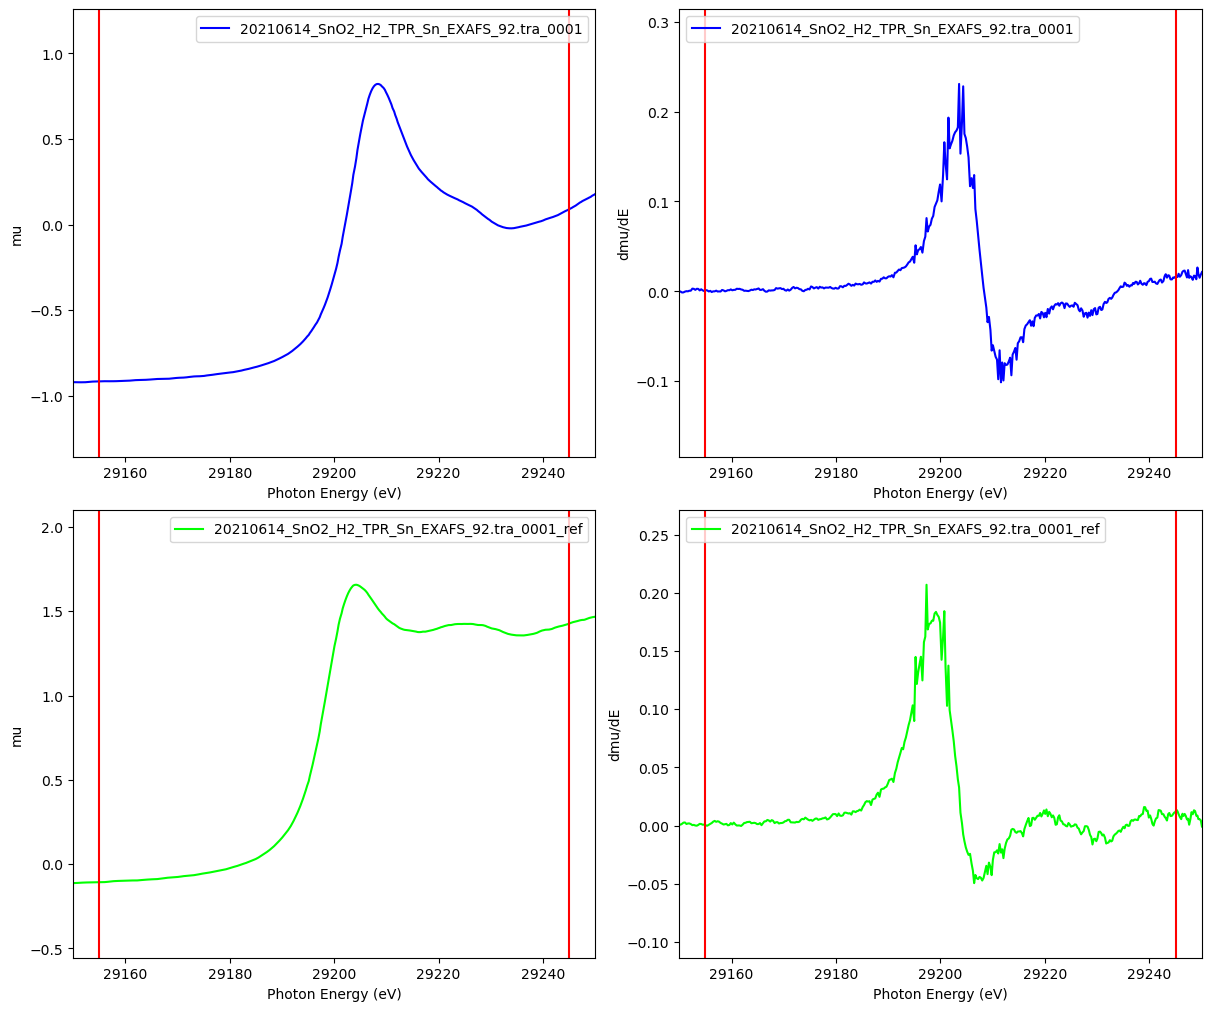

In [11]:
# 1. Visualize absorption spectra of the sample and reference for scan_name.

Samp_group = my_exp.spectra[scan_name]['Absorption Spectra']['mu Sample']
Ref_group = my_exp.spectra[scan_name]['Absorption Spectra']['mu Reference']


pfcts.plot_XANES([Samp_group, Ref_group], emin, emax, spectra = 'mu',  
                 e0 = None, e0_line = True, ref_lines = [emin+5, emax-5], 
                 deriv = True, overlay = False,
                 filtering = True, window_length = 21, polyorder = 4)

## Step 7. Calibrate Energy and Find E0

    Calibration has 2 steps:
        a. Find the edge of the reference spectra and determine the energy shift (delE)
        b. find the E0 value for the sample spectra

    Calibration should be perfromed with the reference channel if possible.
    Calibration can be skipped, however a second step will be needed to set the E0 value for the appropriate spectra [Commented out in example]

    Calibration will find the first inflection point of the data based upon the range set by the suppled values of Ref_E0 value and energy_range.
        Range = Ref_E0 +/- energy_range

    For the reference and the sample, the use_mean parameter will set each spectrum to the mean E0 value found. This is useful as there is no data smoothing on the reference, and will pick an average value for the sample if it is transient.

### Major steps for adding data to the Experiment class:
    a. Calibrate Reference Spectra
    b. Find Sample E0


### 7a. Calibrate Reference Spectra

    There are two options for energy calibration:
        1. Semi-automated - software finds the first derivative maximum in a specified energy range of reference channel
        2. Manual - select edge of reference channel using plot function


    Use either method by converting the code block(s) from "RawNBConvert" to "Code" using the dropdown option at the top fo the screen.

#### MODIFY:
    1. Ref_E0 - set to known energy value for the reference channel
    2. energy_range - how far to look around the theiretical edge to find an inflection point
    3. use_mean - True or False, determiend if each spetra has a unique E0 or if it shared

In [12]:
# Option 2a: Manual edge calibration - Find the Edge

samp_ref = 'mu Reference'
spectra = 'mu'
deriv = True
e0 = None
e0_line = False 
ref_lines = (emin, emax, 0.05)
overlay = True
use_legend = False
cmap_name = 'brg'
filtering = False
window_length = 31
polyorder = 4

# Reset delE
delE_params = {'delE': 0,
              'e0': None}

# Sample
my_exp.load_params('mu Sample', delE_params)

# Reference
my_exp.load_params('mu Reference', delE_params)

interact(my_exp.plot_XANES_spectra,
         emin = fixed(emin),
         emax = fixed(emax),
         samp_ref = fixed(samp_ref),
         spectra = fixed(spectra),
         deriv = fixed(deriv),
         e0 = fixed(e0),
         e0_line = fixed(e0_line),
         ref_lines = ref_lines,
         overlay = fixed(overlay),
         use_legend = fixed(use_legend),
         cmap_name = fixed(cmap_name),
         filtering = fixed(filtering),
         window_length = fixed(window_length),
         polyorder = fixed(polyorder))

interactive(children=(FloatSlider(value=29200.0, description='ref_lines', max=29250.0, min=29150.0, step=0.05)…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [13]:
# Option 2b: Manual edge calibration - Apply del E and E0

# Modify as needed:

found_edge = 29198.90

# DO NOT NEED TO MODIFY BELOW
delE = Edge_Energy-found_edge

ref_edge_params = {'delE': delE,
                   'e0': Edge_Energy}

samp_edge_params = {'delE': delE}

# Sample
my_exp.load_params('mu Sample', samp_edge_params)

# Reference
my_exp.load_params('mu Reference', ref_edge_params)

print(f'delE parameter: {delE:0.2f}')

delE parameter: 1.10


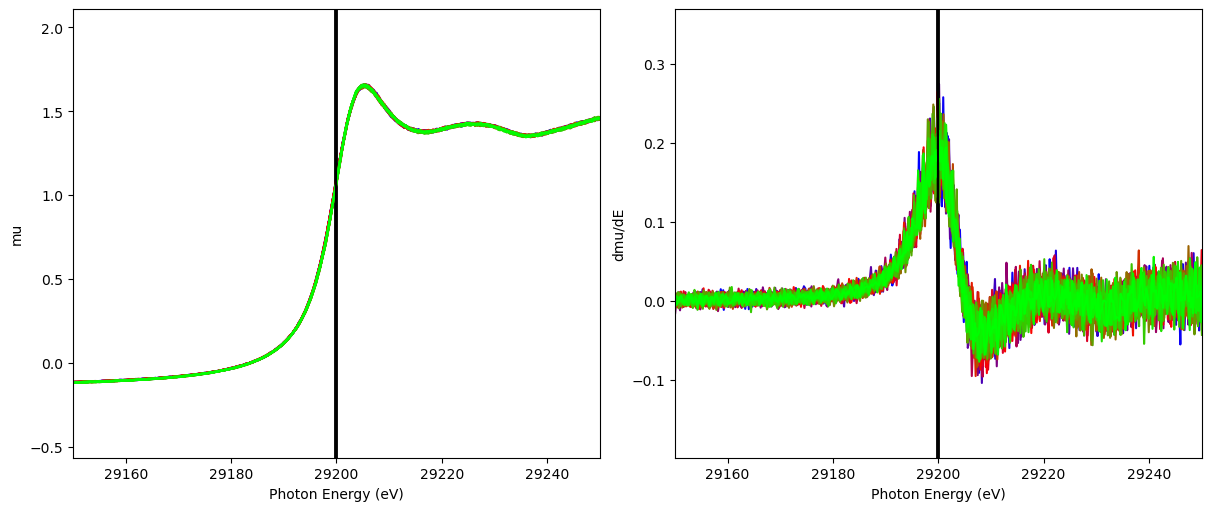

In [14]:
# Option 2b: Manual edge calibration - Check Energy Calibration with Reference Channel

my_exp.plot_XANES_spectra(emin, emax, samp_ref = 'mu Reference', spectra = 'mu', deriv = True, 
                          e0 = None, e0_line = True, 
                          ref_lines = None, overlay = True, use_legend = False, cmap_name = 'brg', 
                          filtering = False, window_length = 5, polyorder = 2)

### 7b. Find Sample E0
    
    There are two options for sample edge (E0) finding:
        1. Semi-automated - software finds the first derivative maximum in a specified energy range of the sample
        2. Manual - select edge of sample channel using plot function


    Use either method by converting the code block(s) from "RawNBConvert" to "Code" using the dropdown option at the top fo the screen.

#### MODIFY:
    1. Samp_e0 - approximate edge position of the sample
    2. energy_range - how far to look around the theiretical edge to find an inflection point
    3. use_mean - True or False, determiend if each spetra has a unique E0 or if it shared

In [15]:
# Option 2a: Manual edge finding

# Modify as needed:


# DO NOT NEED TO MODIFY BELOw
samp_ref = 'mu Sample'
spectra = 'mu'
deriv = True
e0 = None
e0_line = False 
ref_lines = (emin, emax, 0.05)
overlay = True
use_legend = False
cmap_name = 'brg'
filtering = True
window_length = 21
polyorder = 2

interact(my_exp.plot_XANES_spectra,
         emin = fixed(emin),
         emax = fixed(emax),
         samp_ref = fixed(samp_ref),
         spectra = fixed(spectra),
         deriv = fixed(deriv),
         e0 = fixed(e0),
         e0_line = fixed(e0_line),
         ref_lines = ref_lines,
         overlay = fixed(overlay),
         use_legend = fixed(use_legend),
         cmap_name = fixed(cmap_name),
         filtering = fixed(filtering),
         window_length = fixed(window_length),
         polyorder = fixed(polyorder))

interactive(children=(FloatSlider(value=29200.0, description='ref_lines', max=29250.0, min=29150.0, step=0.05)…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [16]:
# Option 2b: Manual edge finding - Apply  E0

# Modify as needed:

found_edge = 29201.60

# DO NOT NEED TO MODIFY BELOW

samp_edge_params = {'e0': found_edge}

# Sample
my_exp.load_params('mu Sample', samp_edge_params)

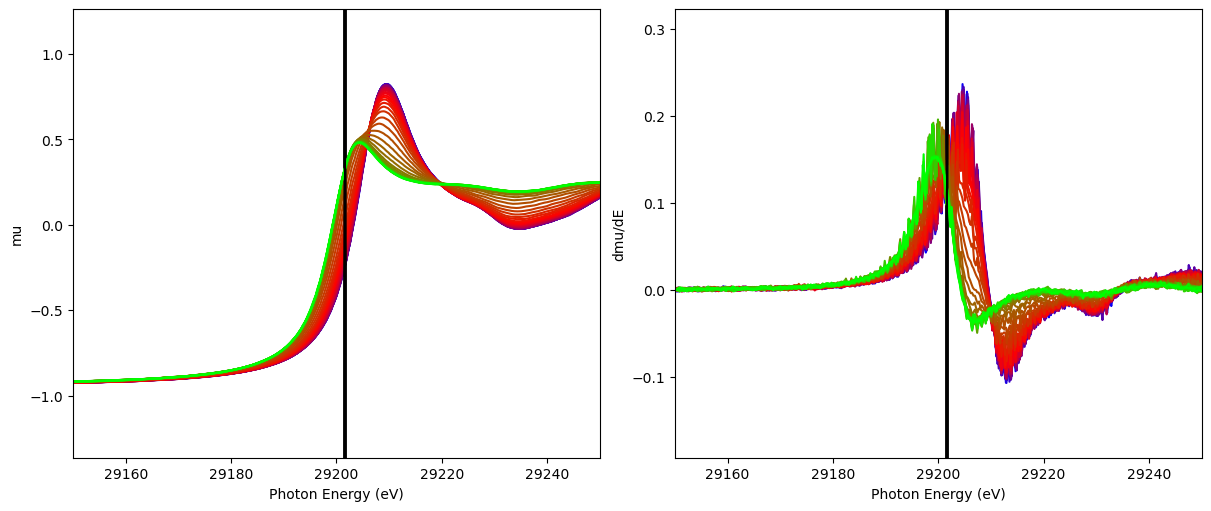

In [17]:
# Option 2b: Manual edge finding - Check Edge position of Sample Channel

my_exp.plot_XANES_spectra(emin, emax, samp_ref = 'mu Sample', spectra = 'mu', deriv = True, 
                          e0 = None, e0_line = True, 
                          ref_lines = None, overlay = True, use_legend = False, cmap_name = 'brg', 
                          filtering = True, window_length = 21, polyorder = 4)

## Step 8. Remove BL data from experimental class

In [18]:
for key in my_exp.__dict__['spectra'].keys():
    my_exp.__dict__['spectra'][key].pop('BL Data')

## Step 9. Normalize Spectra

    Normalization using the same parameters as Athena.

### Major steps for normalization will:
    a. Scan the energy ranges of the data and suggest normalization parameters (spectra files need an E0 value)
    b. Set the normalization parameters
    c. Normalize the spectra

### 9a. Define normalization paramaters

In [19]:
# Inspect each spectrum's energy range and suggest normalization paramters

df1 = my_exp.check_Energy_Range(has_e0 = True, spectra_name = 'mu Sample', print_summary = True)

df2 = my_exp.check_Energy_Range(has_e0 = True, spectra_name = 'mu Reference', print_summary = True)

Energy Range and Energy-Step Summary for mu Sample
	Variation in starting energy points between spectra [eV]: 29004.24-29004.75
	Variation in ending energy points between spectra [eV]: 30175.00-30175.45
	Variation in step size of energy points between spectra [eV]: 0.24-0.24

Normalization Parameters for mu Sample
	Edge Energy Range [E0]: 29201.60-29201.60 eV
	Pre-edge start/stop Suggestion [pre1/pre2]: -150/-50
	Post-edge start/stop Suggestion [norm1/norm2]: 75/700
	Normalizaion order Suggestion [nnorm]: 2
	Flatten Spectra Suggestion [make_norm]: True

Energy Range and Energy-Step Summary for mu Reference
	Variation in starting energy points between spectra [eV]: 29004.24-29004.75
	Variation in ending energy points between spectra [eV]: 30175.00-30175.45
	Variation in step size of energy points between spectra [eV]: 0.24-0.24

Normalization Parameters for mu Reference
	Edge Energy Range [E0]: 29200.00-29200.00 eV
	Pre-edge start/stop Suggestion [pre1/pre2]: -150/-50
	Post-edge start/s

### 9b. Normalzie Reference Spectra

In [20]:
# Update values in the dictionary based upon summary results above

#Refernece Normalization paramters, referenced to E0
Ref_norm_params = {'pre1': -175,
                    'pre2': -100,
                    'norm1': 120,
                    'norm2': 900,
                    'nnorm': 2,
                    'make_flat': True
                   }

my_exp.load_params('mu Reference', Ref_norm_params)

my_exp.normalize_spectra('mu Reference')

# Check Normalization
R_groups = []


for key in my_exp.spectra.keys():
    R_groups.append(my_exp.spectra[key]['Absorption Spectra']['mu Reference'])
    

interact(pfcts.plot_NormXANES,
         larch_group = R_groups)

interactive(children=(Dropdown(description='larch_group', options=(<Group 20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra…

<function plot.plot_NormXANES(larch_group)>

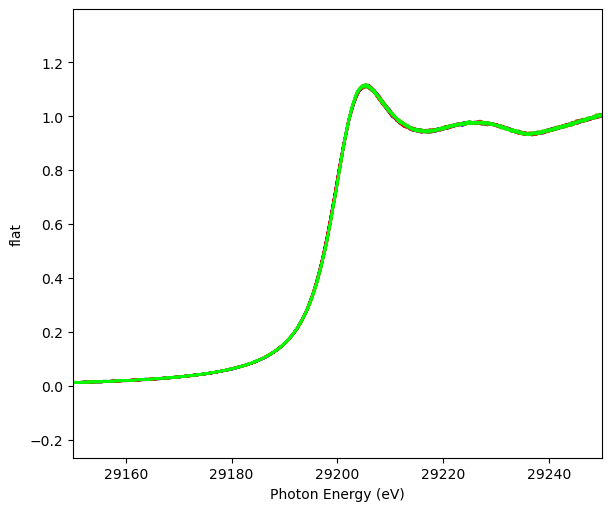

In [21]:
# Visualization of Normalized Spectra - Reference

pfcts.plot_XANES(R_groups, emin, emax, spectra = 'flat', 
                 deriv = False, e0 = None, e0_line = False, 
                 overlay = True, use_legend = False)

### 9c. Normalize Sample Spectra

In [22]:
# Update values in the dictionary based upon summary results above

#Sample Normalization paramters, referenced to E0
Samp_norm_params = {'pre1': -175,
                    'pre2': -100,
                    'norm1': 75,
                    'norm2': 900,
                    'nnorm': 2,
                    'make_flat': True
                   }

my_exp.load_params('mu Sample', Samp_norm_params)

my_exp.normalize_spectra('mu Sample')


# Check Normalization
S_groups = []


for key in my_exp.spectra.keys():
    S_groups.append(my_exp.spectra[key]['Absorption Spectra']['mu Sample'])
    

interact(pfcts.plot_NormXANES,
         larch_group = S_groups)

interactive(children=(Dropdown(description='larch_group', options=(<Group 20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra…

<function plot.plot_NormXANES(larch_group)>

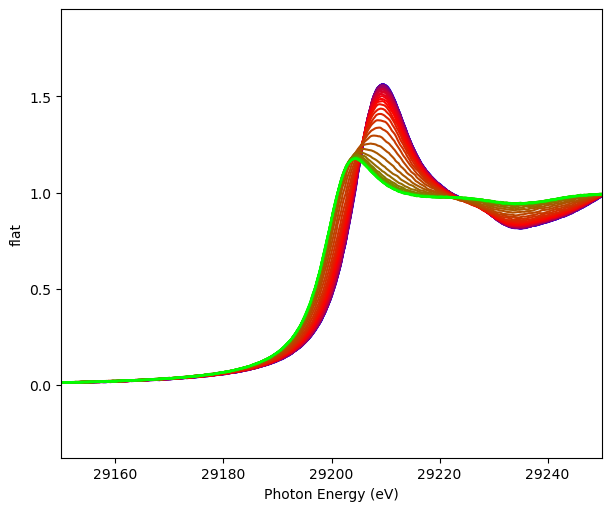

In [24]:
#. Visualization of Normalized Spectra - Sample

    
pfcts.plot_XANES(S_groups, emin, emax, spectra = 'flat', 
                 deriv = False, e0 = None, e0_line = False, 
                 overlay = True, use_legend = False)

## Step 10. Add Process Data to Experiment 

    Note: Additiona datastreams will need their own functions. Please reach out with questions.

In [ ]:
# Add Mass Spec Dataset
my_exp.import_massspec(MS_filename)

# Add LabView Dataset
my_exp.import_labview(LV_filename)

In [ ]:
# Display mass spec datafram   NOT REALLY NEEDED, good visual that it worked

my_exp.process_params['MS Data']

## Step 11. Correlate Process Parameters to XAS data

    This step interpolates values from the parameter datasets onto the XAS spectra time grid.

In [ ]:
my_exp.correlate_process_params()

In [ ]:
# Visualize Correlation Table

my_exp.summary['XAS Spectra Process Params']

## Step 12. Perform LCF

    Notes:
        a. Basis sets must be larch groups that have been calibrated and normalized
        

### Major steps for performing LCF:
    
    a. Generate list of basis spectra groups
    b. Load basis set into a "Fit"
    c. Perform LCF
    d. Generate a Fit Report
    e. Visualize Fit and Errors with one Process Parameter
    f. Visulaize Single Fit

### 12a. Generate list of basis spectra groups

    In this section we ae using three basis spectra that are taken from the main data set, not standards.
        1. First Scan (*_0001)
        2. ~Middle Scan (*_0031)
        3. Last Scan (*_0050)
        
    Notes:
        1. Each basis gropu must have its own name.
        2. Basis are compiled into a list prior to uploading into the experiment

In [ ]:
# Basis set made from three spectra in the sample dataset
basis1 = my_exp.spectra['20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0001']['Absorption Spectra']['mu Sample'] 
basis1.name = '20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0001'

basis2 = my_exp.spectra['20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0031']['Absorption Spectra']['mu Sample']
basis2.name = '20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0031'

basis3 = my_exp.spectra['20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0050']['Absorption Spectra']['mu Sample']
basis3.name = '20210614_SnO2_H2_TPR_Sn_EXAFS_92.tra_0050'

basis = [basis1, basis3]

### 12b. Load basis set into a "Fit"

    Each LCF fit can be saved under a different "Fit name". Choosing the same name will overwrite a former Fit

#### MODIFY:
    1. fit_name - unique name for the fit

In [ ]:
# Load list of basis spectra into the experiment

my_exp.load_lcf_basis(basis, fit_name)

In [ ]:
# Visualize basis sets for fitting

basis_groups = my_exp.analysis['LCF'][fit_name]['basis spectra']

pfcts.plot_XANES(basis_groups, emin, emax, spectra = 'flat', 
                 deriv = False, e0 = None, e0_line = False, 
                 overlay = True, use_legend = False)

### 12c. Perform LCF

    This fitting step allows different paramters to updated and the fit to be performed.  This step can be run multiple times as needed.

#### MODIFY:
    1. fit_name - which fit is being completed 
    2. emin - starting energy range for the LCF
    3. emax - ending enregy range for the LCF
    4. minvals - minimum values that fits can be at (lower limit of component fraction)
    5. maxvals - maximum values that fits can be at (upper limit of component fraction)
    6. array_name - what spectra to fit, 'mu', 'norm', 'flat' are common options
    7. sum_to_one - True = all components fractions must sum to 1, False = component fractions can some to anything
    

In [ ]:
# Fit the sample spectra
emin_fit = Edge_Energy-50
emax_fit = Edge_Energy+50
minvals = 0
maxvals = 1
array_name = 'flat'
sum_to_one = True

my_exp.fit_LCF(fit_name, emin_fit, emax_fit, 
               weights = None, minvals = minvals, maxvals = maxvals, 
               arrayname = array_name, sum_to_one = sum_to_one)

### 12d. Generate a Fit Report

    This step compiles all the LCF results for each spectr into a easy to read dataframe into "Fit Summary"

In [ ]:
# Generate fit report for all spectra

my_exp.lcf_report(fit_name)

In [ ]:
# Contents of the Fit Summary
my_exp.analysis['LCF'][fit_name]['Fit Summary']

### 12e. Visualize Fit and Errors with one Process Parameter

#### Modify:
    1. fit_name
    2. process_param - name of parameter from a process stream. Common option is temperature (from LV:'TR1 T [°C]')

In [ ]:
# Visualize Fit with process parameter

process_param = 'TR1 T [°C]'

my_exp.plot_LCF_results(fit_name, process_parameter = process_param)

In [ ]:
# Visualize individual fits

ymin = -0.05
ymax = 1.6


interact(my_exp.plot_LCF, spectra = my_exp.spectra.keys(),
        fit_name = fixed(fit_name),
        emin = fixed(emin), emax = fixed(emax), 
        ymin = fixed(ymin), ymax = fixed(ymax))

## 13. Exporting Data

### 13a. XAS-process parameter correlation table

In [ ]:
# Save Correlation Dataframe

my_exp.save_processparams(os.path.join(output_dir,fname_correlation))

### 13b. LCF fitting results

    Notes:
        1. if save_spectra = True each spectra will be saved alogn with its fit result and fractional components of each spectra in the basis set

In [ ]:
my_exp.save_lcf_results(os.path.join(output_dir,fname_LCFReport_name), 
                        fit_name, save_spectra = True)

### 13c. Interpolated XAS spectra (XANES)

    It may be useful to export the spectra on a uniform grid with a specific energy range.  Common uses are for:
        1. plotting in non-python siftware
        2. taking a subset of the data for use in alternative analysis packages (UU PCA/MCR-ALS)

#### Sub steps for saving interpolated spectra:
    1. Determine the largest possible energy range and step size - this looks for the largest startign erngy value, smallest ending energy, and average step size to to determine over/under sampling.
    2. Perform the interpolation based upon start/stop/step size.
    3. Save the data to a user specified .csv file and path
    
#### 13c-1. Determinin largest interpolation range given XAS structure

In [ ]:
df = my_exp.check_Energy_Range(has_e0 = False, spectra_name = 'mu Sample', print_summary = True)

#### 13c-2. Perform the interpolation based upon start/stop/step size

interpolation writes a dataframe to the exepriemnt.summary dictionary.

##### Modify:
    1. Start - energy to start the interpolation at
    2. Stop - energy to stop interpolation
    3. Step - energy step to interpolate on

In [ ]:
# Set the energy range and step size to interpolate onto
start = 29050
stop = 29450
step = 0.25

In [ ]:
# Interpolate Spectra
my_exp.interpolate_spectra(start, stop, step, x_axis = 'energy', sample = 'mu Sample')

In [ ]:
# Visualzie interpolated spectra with plot

my_exp.__dict__['summary']['Interpolated energy'].plot(legend=False)

#### 13c-3. Save the dataframe to a csv file

In [ ]:
# Save Normalized XANES:

my_exp.save_interpXAS(os.path.join(output_dir,fname_interpXAS))

## Step 14. Save Experiment with 'pickle'

    Pickle - A method to save the experimental class and reopen it elsewhere.

In [ ]:
pickle_path = os.path.join(pickle_dir,pickle_name)

pickle_out = open(pickle_path,"wb")
pickle.dump(my_exp, pickle_out)
pickle_out.close()